# Задание

In [52]:
#функция качества хромосомы
def qZ(x, y):
    return (x - 3 * y + 1) / (3 * x ** 2 + y ** 2 + 1)

In [53]:
#сумма качества хромосом
def qSumZ(Z):
    return sum(Z)

In [54]:
def exchangeScheme(oldX, oldY, sortedId):
    x = [0 for i in range(4)]
    y = [0 for i in range(4)]
    
    x[2] = oldX[sortedId[2]]
    x[3] = oldX[sortedId[2]]
    
    x[0] = oldX[sortedId[0]]
    
    x[1] = oldX[sortedId[1]]
    
    y[0] = oldY[sortedId[2]]
    y[1] = oldY[sortedId[2]]
    
    y[2] = oldY[sortedId[0]]
    
    y[3] = oldY[sortedId[1]]
    
    return x, y

In [55]:
def sorting(Z):
    sortedId = sorted(range(len(Z)), key=lambda k: Z[k])
    return sortedId

In [56]:
#шаг эволюции
def evoStep(x, y, z):
    _, minId = min((value, id) for (id, value) in enumerate(z))
    x = x[:]
    y = y[:]
    z = z[:]
    
    x.pop(minId)
    y.pop(minId)
    z.pop(minId)
    
    return x, y, z

In [57]:
#шаги эволюции (конечная функция), по умолчанию 4 шага
def evoSteps(x, y, steps_num=4):
    results = []
    
    for i in range(steps_num):
        arrZ = [qZ(k, y[i]) for i, k in enumerate(x)]
        
        x, y, z = evoStep(x, y, arrZ)
        
        x, y = exchangeScheme(x, y, sorting(z))
        
        results.append([x, y, qSumZ(arrZ), arrZ])
    
    return x, y, results

In [58]:
# объявление массивов хромосом
x = [-2, -1, 0, 2]
y = [-2, 0, -1, 1]

# реализация алгоритма
results = evoSteps(x, y)

In [59]:
for i in range(len(results[2])):
    print(f'max_{i + 1}_step: {results[2][i][2]}')

qualityArrZ = []
for i in range(len(results[2])):
    qualityArrZ += results[2][i][3]

print(f'max Z: {max(qualityArrZ)}')

max_1_step: 2.2941176470588234
max_2_step: 0.9714285714285713
max_3_step: 4.823529411764706
max_4_step: 5.828571428571428
max Z: 2.0


# Задание

In [60]:
import networkx as nx
from math import e
distances = [(1, 2, 18),
            (1, 3, 41),
            (1, 4, 36), 
            (1, 5, 29),
            (1, 6, 19),
            (2, 3, 27),
            (2, 4, 31),
            (2, 5, 37),
            (2, 6, 15),
            (3, 4, 19),
            (3, 5, 42),
            (3, 6, 23),
            (4, 5, 24),
            (4, 6, 17),
            (5, 6, 24)] #длины рёбер

V = [1, 3, 4, 5, 6, 2, 1] #последовательность прохождения маршрута
Z = [(2, 4),
    (3, 4),
    (4, 6),
    (5, 4)] #последовательность замен вершин
P = [63, 49, 45, 53] #случайные числа, выпавшие в процессе счёта

T = 100 #начальная температура

In [61]:
#функция вероятности
def probability(delta, T):
    return 100 * e ** (-delta / T)

#функция изменения температуры
def reductTemp(prevT):
    nextT = 0.5 * prevT
    return nextT

In [62]:
# вычисление длины ребра
def edgeLength(i, j, distances, roundTrip=True):
    if roundTrip:
        return max([(item[2] if (item[0] == i and item[1] == j) or (item[1] == i and item[0] == j) else -1)
                   for item in distances])
    else:
        return max([(item[2] if (item[0] == i and item[1] == j) else -1) for item in distances])

In [63]:
# вычисление длины маршрута
def routeLength(V, distances):
    edges = []
    
    for i in range(len(V) - 1):
        edges.append(edgeLength(V[i], V[i + 1], distances))
    
    return sum(edges)

In [64]:
#одна перестановка в пути
def routeOneReplacement(arrV, Z, replacementByName=True):
    decrement = 1 if replacementByName else 0
    
    arrV[Z[0] - decrement], arrV[Z[1] - decrement] = arrV[Z[1] - decrement], arrV[Z[0] - decrement]

    return arrV

In [65]:
#перестановка в пути
def routeReplacement(V, Z):
    for z in Z:
        V = routeOneReplacement(V, z)
    return V

In [66]:
#выбор нужного пути методом отжига
def chooseRoute(distances, V, Z, T, P):
    sumLength = routeLength(V, distances) #нахождение длины пути
    arrSum = [sumLength] #массив сумм длин
    
    #циклы методом отжига
    for i in range(len(Z)):
        newV = routeOneReplacement(V[:], Z[i]) #новый маршрут после перестановки
        newS = routeLength(newV, distances) #длина нового маршрута
        arrSum.append(newS)
        deltaS = newS - sumLength #разница между длиной нового и старого маршрутов
        
        #в случае, если разница между длинами больше 0, то вычисляется вероятность
        if deltaS > 0:
            p = probability(deltaS, T) #подсчёт вероятности
            
            #если заданная вероятность попадает в интервал от 0 до p, то новый маршрут выбирается
            if p > P[i]:
                V = newV
                sumLength = newS
        else:
            V = newV
            sumLength = newS
            
        T = reductTemp(T) #вычисление температуры
    
    return V, arrSum

In [67]:
#отрисовка графа по заданному маршруту
def drawRouteGraph(distances, bestRoute):
    newDistances = []
    #прохождение по вектору
    for i in range(len(bestRoute) - 1):
        for distance in distances:
            if distance[0] == bestRoute[i] and distance[1] == bestRoute[i + 1] or distance[1] == bestRoute[i] and distance[0] == bestRoute[i + 1]:
                newDistances.append(distance)
    
    graph = nx.Graph() #создание пустого графа
    
    graph.add_weighted_edges_from(newDistances) #добавление весов рёбер
    #отрисовка графа с заданными вершинами
    nx.draw_kamada_kawai(graph, node_color='#fb7258', node_size=2000, with_labels=True)

Лучший выбранный маршрут: [1, 5, 3, 4, 6, 2, 1]
Длина лучшего выбранного маршрута: 140
Длины всех рассмотренных маршрутов: [141, 128, 140, 166, 160]


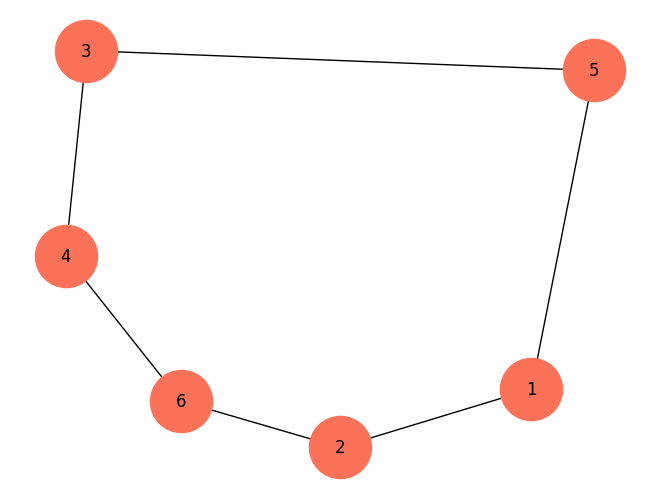

In [68]:
bestRoute, arrLength = chooseRoute(distances, V, Z, T, P)

print(f'Лучший выбранный маршрут: {bestRoute}')
print(f'Длина лучшего выбранного маршрута: {routeLength(bestRoute, distances)}')
print(f'Длины всех рассмотренных маршрутов: {arrLength}')

drawRouteGraph(distances, bestRoute) #отрисовка лучшего маршрута